In [12]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [19]:
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Settings and Dataset

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cpu')

In [25]:
#hyperparameters
random_seed=123
learning_rate = 0.01
num_epochs = 10
batch_size = 256

#architecture
num_features = 784
num_classes = 10

train_dataset = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#checking the dataset
for images, labels in train_loader:
  print("Image batch dimensions", images.shape)
  print("Image label dimensions", labels.shape)
  break

Image batch dimensions torch.Size([256, 1, 28, 28])
Image label dimensions torch.Size([256])


In [26]:
class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0

    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float() / num_examples * 100


start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)

        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_dataset)//batch_size, cost))

    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs,
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/234 | Cost: 2.3026
Epoch: 001/010 | Batch 050/234 | Cost: 1.8588
Epoch: 001/010 | Batch 100/234 | Cost: 1.5193
Epoch: 001/010 | Batch 150/234 | Cost: 1.3405
Epoch: 001/010 | Batch 200/234 | Cost: 1.2268
Epoch: 001/010 training accuracy: 81.52%
Time elapsed: 0.28 min
Epoch: 002/010 | Batch 000/234 | Cost: 1.1732
Epoch: 002/010 | Batch 050/234 | Cost: 0.9597
Epoch: 002/010 | Batch 100/234 | Cost: 0.9617
Epoch: 002/010 | Batch 150/234 | Cost: 0.9100
Epoch: 002/010 | Batch 200/234 | Cost: 0.8789
Epoch: 002/010 training accuracy: 83.72%
Time elapsed: 0.77 min
Epoch: 003/010 | Batch 000/234 | Cost: 0.8430
Epoch: 003/010 | Batch 050/234 | Cost: 0.8486
Epoch: 003/010 | Batch 100/234 | Cost: 0.7320
Epoch: 003/010 | Batch 150/234 | Cost: 0.7345
Epoch: 003/010 | Batch 200/234 | Cost: 0.6827
Epoch: 003/010 training accuracy: 85.23%
Time elapsed: 1.13 min
Epoch: 004/010 | Batch 000/234 | Cost: 0.7631
Epoch: 004/010 | Batch 050/234 | Cost: 0.7244
Epoch: 004/010 | Batch 100

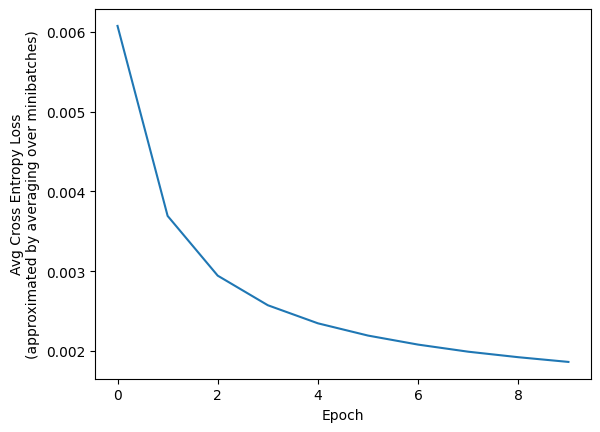

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [29]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 88.81%


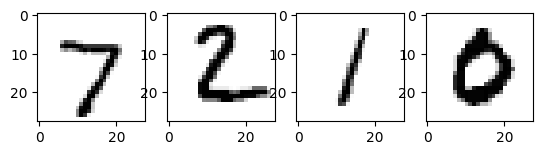

In [30]:
for features, targets in test_loader:
    break

fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [31]:
_, predictions = model.forward(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0])
